In [244]:
import numpy as np
import random
import cv2
import math
import copy
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

# img = Image.open("images/000000000785.jpg")
# img = img.convert("RGB")                   # 图片转为RGB格式
# img = np.array(img)

img = cv2.imread('images/000000000785.jpg', cv2.IMREAD_COLOR)

height = img.shape[0]
width = img.shape[1]
print("img_shape: ", img.shape)
print("height: ", height)
print("width: ", width)

img_show = copy.deepcopy(img)
labels = []
with open('./images/000000000785.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        cls, x, y, w, h = map(float, line.split())
        x1 = int((x - w / 2) * width)
        y1 = int((y - h / 2) * height)
        x2 = int((x + w / 2) * width)
        y2 = int((y + h / 2) * height)
        labels.append([x1, y1, x2, y2])

        img_label = cv2.rectangle(img_show, [x1, y1], [x2, y2], color=(0, 0, 255), thickness=2)

img_shape:  (425, 640, 3)
height:  425
width:  640


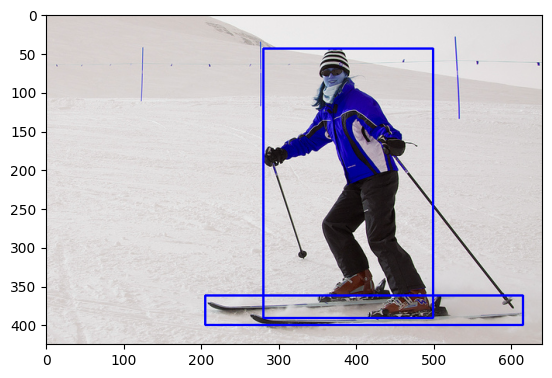

In [245]:
%matplotlib inline

plt.imshow(img_label)
plt.show()

# 上下翻转

In [246]:
img_flipud = np.ascontiguousarray(np.flipud(copy.deepcopy(img)))

for label in labels:
    x1, y1, x2, y2 = label
    y1 = height - y1
    y2 = height - y2
    img_flipud_label = cv2.rectangle(img_flipud, [x1, y1], [x2, y2], color=(0, 0, 255), thickness=2)
    

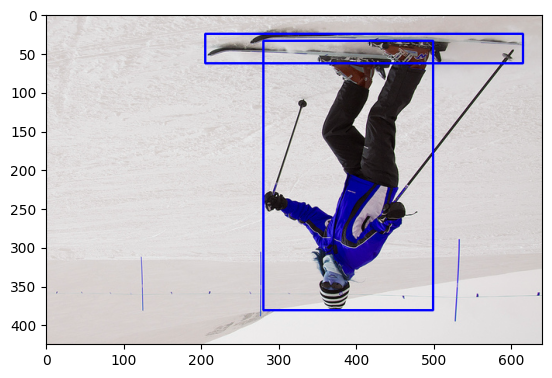

In [247]:
%matplotlib inline

plt.imshow(img_flipud_label) 
plt.show()

# 左右翻转

In [248]:
img_fliplr = np.ascontiguousarray(np.fliplr(copy.deepcopy(img)))

for label in labels:
    x1, y1, x2, y2 = label
    x1 = width - x1
    x2 = width - x2
    img_fliplr_label = cv2.rectangle(img_fliplr, [x1, y1], [x2, y2], color=(0, 0, 255), thickness=2)
    

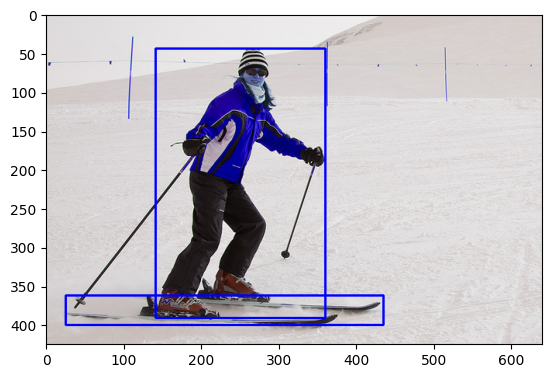

In [249]:
%matplotlib inline

plt.imshow(img_fliplr_label) 
plt.show()

# Perspective

In [250]:
sheer = 0.1
translate = 0.1
scale = 0.1
degree = 0
perspective = 0.0001

In [251]:
C = np.eye(3, dtype=np.float32)

In [252]:
C[0, 2] = -img.shape[1] / 2  # x translation (pixels)
C[1, 2] = -img.shape[0] / 2  # y translation (pixels)
print(C)

[[   1.     0.  -320. ]
 [   0.     1.  -212.5]
 [   0.     0.     1. ]]


In [253]:
P = np.eye(3, dtype=np.float32)
P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
P[2, 1] = random.uniform(-perspective, perspective)
print(P)

[[1.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 1.000000e+00 0.000000e+00]
 [7.054891e-05 4.138843e-05 1.000000e+00]]


In [254]:
R = np.eye(3, dtype=np.float32)
a = random.uniform(-degree, degree)
print('a:', a)
# a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
s = random.uniform(1 - scale, 1 + scale)
print("s:", s)
# s = 2 ** random.uniform(-scale, scale)
R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)
print(R)

a: 0.0
s: 1.0529020912677434
[[ 1.0529021  0.        -0.       ]
 [-0.         1.0529021  0.       ]
 [ 0.         0.         1.       ]]


In [255]:
S = np.eye(3, dtype=np.float32)
S[0, 1] = math.tan(random.uniform(-sheer, sheer) * math.pi / 180)  # x shear (deg)
S[1, 0] = math.tan(random.uniform(-sheer, sheer) * math.pi / 180)  # y shear (deg)
print(S)

[[ 1.0000000e+00 -1.7817010e-05  0.0000000e+00]
 [-1.5632627e-03  1.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [256]:
T = np.eye(3, dtype=np.float32)
T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * img.shape[1]  # x translation (pixels)
T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * img.shape[0]  # y translation (pixels)
print(T)

[[  1.        0.      363.01978]
 [  0.        1.      220.77336]
 [  0.        0.        1.     ]]


In [257]:
M = T @ S @ R @ P @ C
print(M)

[[ 1.0785128e+00  1.5006059e-02  1.4706909e+01]
 [ 1.3929357e-02  1.0620396e+00 -9.3674469e+00]
 [ 7.0548907e-05  4.1388430e-05  9.6862930e-01]]


In [258]:
img_perspective = np.ascontiguousarray(copy.deepcopy(img))
if perspective:    
    img_perspective = cv2.warpPerspective(img_perspective, M, dsize=(img.shape[1], img.shape[0]), borderValue=(114, 114, 114))
else:  # affine
    img_perspective = cv2.warpAffine(img_perspective, M[:2], dsize=(img.shape[1], img.shape[0]), borderValue=(114, 114, 114))

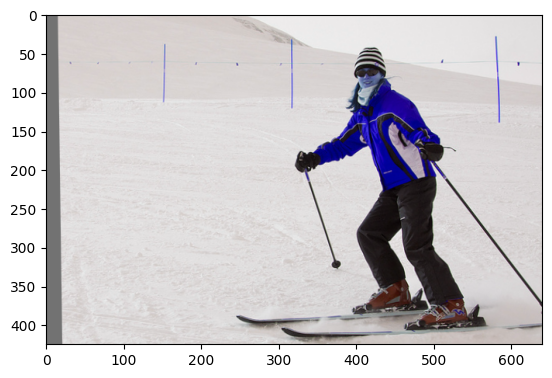

In [259]:
%matplotlib inline
 
# img = np.random.random((128,128,3))
plt.imshow(img_perspective)
plt.show()

In [260]:
n = len(labels)
labels = np.array(labels)
xy = np.ones((n * 4, 3))
xy[:, :2] = labels[:, [0, 1, 2, 3, 0, 3, 2, 1]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
xy = xy @ M.T  # transform
xy = (xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]).reshape(n, 8)  # perspective rescale or affine

# Create new boxes
x = xy[:, [0, 2, 4, 6]]
y = xy[:, [1, 3, 5, 7]]


In [261]:
print('x: ')
print(x)
print('y: ')
print(y)

x: 
[[320.49025143 547.7875981  321.09179513 550.43274705]
 [241.69963155 664.99431305 241.88979328 665.4574549 ]]
y: 
[[ 41.67071881 404.73949245 407.92771673  44.06389484]
 [378.67557462 412.23643043 418.45154703 373.57121531]]


In [262]:
labels_new = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T
print(labels_new)

[[320.49025143  41.67071881 550.43274705 407.92771673]
 [241.69963155 373.57121531 665.4574549  418.45154703]]


In [263]:
for label in labels_new:
    label[0] = max(label[0], 0)
    label[1] = max(label[1], 0)
    label[2] = min(label[2], width)
    label[3] = min(label[3], height)

In [264]:
print(labels_new)

[[320.49025143  41.67071881 550.43274705 407.92771673]
 [241.69963155 373.57121531 640.         418.45154703]]


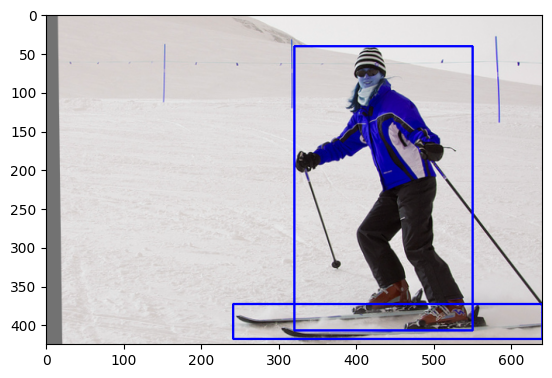

In [265]:
img_perspective = cv2.rectangle(img_perspective, (int(labels_new[0, 0]), int(labels_new[0, 1])), (int(labels_new[0, 2]), int(labels_new[0, 3])), color=(0, 0, 255), thickness=2)
img_perspective = cv2.rectangle(img_perspective, (int(labels_new[1, 0]), int(labels_new[1, 1])), (int(labels_new[1, 2]), int(labels_new[1, 3])), color=(0, 0, 255), thickness=2)

%matplotlib inline
plt.imshow(img_perspective)
plt.show()